# Generalization and Robustness of Fused Ridge Model for Antibiotic Resistance Prediction

This notebook evaluates two key aspects of our **Fused Ridge** model applied to antibiotic resistance prediction using protein sequence features:

### Structure of This Notebook
1. Load per-gene feature matrices and phenotype labels
2. Run subsampling experiments to assess data robustness
3. Analyze the distribution of novel mutations between train/test
4. Summarize trends and visualize key findings (e.g., AUC curves, novelty tables)


In [1]:
# --- Imports and Utilities ---
import os, re, time, json, csv, joblib,sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors


from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, RidgeCV, LogisticRegressionCV
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve

from utility_files.data_loading import *
from utility_files.model_training import train_ridge_model
from utility_files.fused_ridge_gpu import FusedRidge
from utility_files.data_preprocessing import *
from utility_files.distance_processing import *
from utility_files.evaluation import *

## Initialize by gene name

In [2]:
subsampling_rows = []
novelty_stats_rows = []

In [35]:
# --- Configuration ---
gene_name = 'gid'
genes_of_interest = gene_name.split(',')
seed_everything(42)  # Reproducibility

## Required Data files

In [36]:
# --- Load Metadata and Mutation Annotations ---
gene_details = pd.read_csv("data/all_drug_genes_locations.csv")
filtered_df = gene_details[gene_details['gene_name'].str.contains('|'.join(genes_of_interest), case=False, na=False)]
drug_name = filtered_df['drug_full'].values[0].upper()
uniprot = filtered_df['Uniprot'].values[0]
entry = filtered_df['Entry'].values[0]
print(f"Target Gene: {gene_name}, Associated Drug: {drug_name}")


Target Gene: gid, Associated Drug: STREPTOMYCIN


In [37]:
ref_seqs=pd.read_csv('data/protein_sequences.csv')

In [38]:
# variants_df = load_variants("data/mutations_with_one_letter_all.csv")
distmap_path = f"data/distmaps/{uniprot}/{entry}"
dist_map = DistanceMap.from_file(distmap_path)


In [39]:
# # Load mutation annotations and extract positions associated with resistance
# variants_df[['aa_ref', 'aa_pos', 'aa_change']] = variants_df['mutation'].str.extract(r'p\.([A-Za-z]+)(\d+)([A-Za-z]+)')
# variants_df = variants_df[(variants_df['gene'].str.contains(gene_name, case=False, na=False)) &
#                           (variants_df['confidence'].str.contains("Assoc w R", case=False, na=False))]
# variants_df.dropna(subset=['aa_pos'], inplace=True)
# total_actual_positives = len(np.unique(variants_df['aa_pos']))
# print(f"Total confirmed resistance positions: {total_actual_positives}")


## Load training data

In [40]:
# --- Load Feature Matrix and Labels ---
X, y = load_feature_matrix_and_labels(gene_name)
dist_map = DistanceMap.from_file(f"data/distmaps/{uniprot}/{entry}")
# Binary encode phenotype labels
y_encoded = encode_labels(y)

Loading feature matrix and labels for gid from disk.


## Train on unique, de-duplicated data

In [41]:
# --- Deduplicate Data ---
X_unique, original_indices = drop_identical_columns(X)
X_unique_rows, row_selection_indices = drop_identical_sequences(X_unique)
filtered_labels, [X_filtered] = filter_nan_labels(y[row_selection_indices], X_unique_rows)
y_encoded = encode_labels(filtered_labels)
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
X_train, X_test, y_train, y_test = np.array(X_train),np.array(X_test),np.array(y_train),np.array(y_test) 

# --- Train Ridge on Deduplicated Data ---
ridge_model, ridge_score, ridge_auc, ridge_mse = train_ridge_model(X_train, y_train, X_test, y_test)
initial_coef = ridge_model.coef_


## Fused Ridge training module

In [42]:
# --- Subset Features using 3D Distance Map ---
subset_distance_matrix, valid_original_indices, subset_coef, valid_positions = process_distance_matrix(dist_map, original_indices, initial_coef)
scale_param = compute_scale_param(dist_map.dist_matrix)
X_train_subset = X_train[:, np.isin(original_indices, valid_original_indices)]
X_test_subset = X_test[:, np.isin(original_indices, valid_original_indices)]
# --- Load Hyperparameters and Train Fused Ridge ---
optimizer_name='enhanced'
with open("data/best_params.json", 'r') as f:
    best_params = json.load(f)[gene_name][optimizer_name]


## 1. Subsampling Experiment: Training Set Size Robustness
We investigate the effect of varying training data size on model performance. For each gene, we fix a test set and train the model on random subsets of the training data with fractions ranging from 20% to 100%. This experiment helps us assess:

- **Data efficiency**: How much labeled data is sufficient to achieve near-maximum predictive performance.
- **Model scalability**: Whether the model continues to benefit from additional data or plateaus early.
- **Gene-specific sensitivity**: Which genes are more robust vs. more data-hungry.

The results are averaged over multiple random seeds and summarized using **AUC** scores.

In [43]:
# Fixed function with safe final_loss formatting
def run_custom_model_subsampling_fixed_test(
    X_train, y_train, X_test, y_test,
    model_class, model_params,
    set_distance_matrix_fn,
    distance_matrix,
    train_sizes=[0.2, 0.4, 0.6, 0.8, 1.0],
    seeds=[0, 1, 2, 3, 4],
    use_ridge_init=True,
    train_ridge_model=None,
    verbose=True
):
    results = {s: [] for s in train_sizes}

    for seed in seeds:
        rng = np.random.default_rng(seed)
        for frac in train_sizes:
            n_samples = int(frac * len(X_train))
            indices = rng.choice(len(X_train), n_samples, replace=False)
            X_sub = X_train[indices]
            y_sub = y_train[indices]

            if verbose:
                print(f"\ndata shape {X_sub.shape}, frac size {frac}")

            # Step 1: Choose initialization
            if use_ridge_init and train_ridge_model is not None:
                ridge_model, _, _, _ = train_ridge_model(X_sub, y_sub, X_test, y_test)
                initial_coef = ridge_model.coef_
            else:
                initial_coef = np.zeros(X_train.shape[1])

            # Step 2: Inject dynamic init into params
            this_model_params = model_params.copy()
            this_model_params['initial_coef'] = initial_coef

            # Step 3: Train Fused Ridge
            model = model_class(**this_model_params)
            set_distance_matrix_fn(model, distance_matrix)
            model.fit(X_sub, y_sub)

            # Step 4: Evaluate
            y_pred_test = model.predict(X_test)
            auc = roc_auc_score(y_test, y_pred_test)
            results[frac].append(auc)

            if verbose:
                final_loss = getattr(model, 'final_loss', 'NA')
                final_loss_str = f"{final_loss:.4f}" if isinstance(final_loss, (float, int)) else str(final_loss)
                print(f"Ridge score: {ridge_model.score(X_test, y_test):.4f}" if use_ridge_init else "Using zero init.")
                print(f"Converged: {getattr(model, 'converged', 'NA')} | "
                      f"Iterations: {getattr(model, 'iteration', 'NA')} | "
                      f"Final loss: {final_loss_str}")

    # Aggregate summary
    summary = {
        'train_frac': [],
        'mean_auc': [],
        'std_auc': []
    }

    for frac in train_sizes:
        aucs = results[frac]
        summary['train_frac'].append(frac)
        summary['mean_auc'].append(np.mean(aucs))
        summary['std_auc'].append(np.std(aucs))

    return summary



In [44]:
## run subsampling
fused_ridge_params = {
    'optimizer': optimizer_name,
    'alpha': best_params['alpha'],
    'lambda_fuse': best_params['lambda_fuse'],
    'scale_param': scale_param,
    'learning_rate':best_params['learning_rate'],
    'max_iter': 2000,
    'clip_value': 0.9,
    'decay_type': best_params['decay_type'],
    'beta': best_params['beta'],
    'early_stopping': True,
    'tolerance': 1e-6,
    'n_iter_no_change': 50,
    'dimension_threshold':10

}
def set_distance_matrix_fn(model, D):
    model.set_distance_matrix(D)

summary = run_custom_model_subsampling_fixed_test(
    X_train=X_train_subset,
    y_train=y_train,
    X_test=X_test_subset,
    y_test=y_test,
    model_class=FusedRidge,
    model_params=fused_ridge_params,
    set_distance_matrix_fn=set_distance_matrix_fn,
    distance_matrix=subset_distance_matrix,
    use_ridge_init=False,
    train_ridge_model=train_ridge_model,  
    verbose=True
)





data shape (54, 186), frac size 0.2
Iterative optimization applied.
Stopped after reaching max_iter (2000). Final loss: 8.950828067654443
Using zero init.
Converged: False | Iterations: 2000 | Final loss: 8.9508

data shape (109, 186), frac size 0.4
Iterative optimization applied.
Stopped after reaching max_iter (2000). Final loss: 20.353658349904638
Using zero init.
Converged: False | Iterations: 2000 | Final loss: 20.3537

data shape (163, 186), frac size 0.6
Iterative optimization applied.
Stopped after reaching max_iter (2000). Final loss: 29.886287342454736
Using zero init.
Converged: False | Iterations: 2000 | Final loss: 29.8863

data shape (218, 186), frac size 0.8
Iterative optimization applied.
Stopped after reaching max_iter (2000). Final loss: 37.90832863216033
Using zero init.
Converged: False | Iterations: 2000 | Final loss: 37.9083

data shape (273, 186), frac size 1.0
Iterative optimization applied.
Stopped after reaching max_iter (2000). Final loss: 46.814996121467644

In [45]:
formatted_row = {
    'gene': gene_name,
    'train_fracs': [round(v, 2) for v in summary['train_frac']],
    'mean_aucs': [round(v, 4) for v in summary['mean_auc']],
    'std_aucs': [round(v, 4) for v in summary['std_auc']],
    'avg_auc': round(np.mean(summary['mean_auc']), 4)
}
subsampling_rows.append(formatted_row)

In [46]:

# Ensure the columns are treated as numeric types
# subsampling_results['train_fracs'] = subsampling_results['train_fracs'].apply(eval)
# subsampling_results['mean_aucs'] = subsampling_results['mean_aucs'].apply(eval)
# subsampling_results['std_aucs'] = subsampling_results['std_aucs'].apply(eval)

## 2. Novel Mutation Analysis: Generalization to Unseen Variants
To test the model's ability to generalize to **out-of-distribution (OOD)** resistance mutations, we quantify the proportion of test-set mutations that were not seen in the training set (post genotype deduplication). This analysis shows:

- Which genes exhibit high novelty (e.g., gyrA, rpsL, embB)
- Whether the dataset naturally introduces a generalization challenge via unseen variants
- The implications for resistance prediction in real-world, evolving bacterial populations

This also justifies our evaluation setup, which implicitly tests OOD generalization without needing manual mutation holdout.


In [51]:

def build_col_to_mutation_map(reference_seq):
    """
    Build mapping from column index to mutation label.
    Assumes:
    - Column 0: frameshift flag
    - Column 1..L: amino acid differences from H37Rv at positions 1..L
    """
    col_to_mut = {0: 'frameshift'}
    for pos, ref_aa in enumerate(reference_seq):
        col_to_mut[pos + 1] = f'{ref_aa}{pos + 1}X'  # e.g., S315X
    return col_to_mut

def extract_mutations(X_subset, col_to_mutation):
    """
    Given a subset of the feature matrix, return the set of active mutations.
    """
    rows, cols = X_subset.nonzero()
    return set(col_to_mutation[col] for col in np.unique(cols))

def analyze_novel_mutations(X, y, reference_seq):
    """
    Main analysis logic: train/test split, mutation tracking.
    """
    # Build mapping from column index to mutation
    col_to_mutation = build_col_to_mutation_map(reference_seq)

    # Train/test split
    y_encoded = encode_labels(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

    # Extract mutations
    train_mutations = extract_mutations(X_train, col_to_mutation)
    test_mutations = extract_mutations(X_test, col_to_mutation)

    novel_mutations = test_mutations - train_mutations
    shared_mutations = test_mutations & train_mutations

    # Print results
    print(f"Feature matrix shape: {X.shape}")
    print(f"Total test mutations: {len(test_mutations)}")
    print(f"Novel mutations in test set: {len(novel_mutations)}")
    print(f"Shared mutations in test set: {len(shared_mutations)}")
    print(f"\nExamples of novel mutations: {list(novel_mutations)[:5]}")
    print(f"Examples of shared mutations: {list(shared_mutations)[:5]}")
    print(f"\nNovel mutation % in test set: {100 * len(novel_mutations) / len(test_mutations):.2f}%")
    
    return {
        'train_mutations': train_mutations,
        'test_mutations': test_mutations,
        'novel_mutations': novel_mutations,
        'shared_mutations': shared_mutations
    }

def analyze_novel_mutations_from_split(X_train, X_test, reference_seq):
    col_to_mutation = build_col_to_mutation_map(reference_seq)
    
    train_mutations = extract_mutations(X_train, col_to_mutation)
    test_mutations = extract_mutations(X_test, col_to_mutation)

    novel_mutations = test_mutations - train_mutations
    shared_mutations = test_mutations & train_mutations
    # Remove 'frameshift' from both sets (if present)
    novel_mutations.discard('frameshift')
    shared_mutations.discard('frameshift')

    print(f"Train set size: {X_train.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")
    print(f"Total test mutations: {len(test_mutations)}")
    print(f"Novel mutations in test set: {len(novel_mutations)}")
    print(f"Shared mutations in test set: {len(shared_mutations)}")
    print(f"\nExamples of novel mutations: {list(novel_mutations)[:5]}")
    print(f"\nNovel mutation % in test set: {100 * len(novel_mutations) / len(test_mutations):.2f}%")

    return {
        'train_mutations': train_mutations,
        'test_mutations': test_mutations,
        'novel_mutations': novel_mutations,
        'shared_mutations': shared_mutations
    }



In [52]:

h37rv_aa_str = ref_seqs.loc[ref_seqs['gene'] == gene_name, 'protein_sequence'].values[0]
ref_genome =  ref_seqs.loc[ref_seqs['gene'] == gene_name, 'genome_sequence'].values[0]

In [53]:
# Run the mutation analysis
results = analyze_novel_mutations_from_split(X_train, X_test, h37rv_aa_str)

Train set size: 273
Test set size: 69
Total test mutations: 205
Novel mutations in test set: 3
Shared mutations in test set: 201

Examples of novel mutations: ['V203X', 'N194X', 'R197X']

Novel mutation % in test set: 1.46%


In [54]:
row = {
    'gene': gene_name,
    'train_samples': X_train.shape[0],
    'test_samples': X_test.shape[0],
    'total_test_mutations': len(results['test_mutations']),
    'novel_test_mutations': len(results['novel_mutations']),
    'shared_test_mutations': len(results['shared_mutations']),
    'novel_mutation_pct': 100 * len(results['novel_mutations']) / len(results['test_mutations']) if results['test_mutations'] else 0,
    'example_novel_mutations': list(results['novel_mutations'])[:5]
}
novelty_stats_rows.append(row)


## plot final results

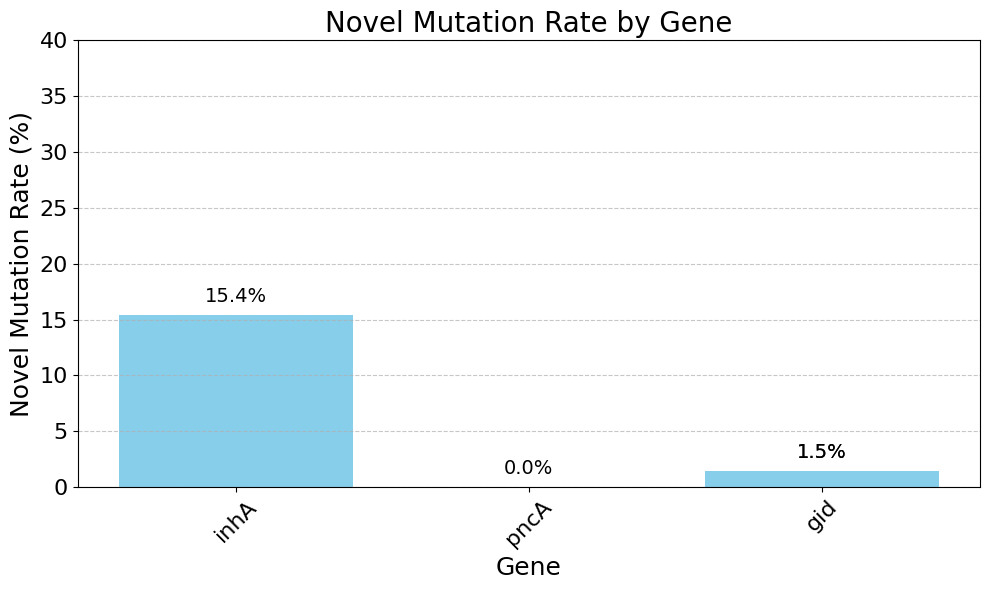

In [55]:
novelty_df=pd.DataFrame(novelty_stats_rows)
# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(novelty_df['gene'], novelty_df['novel_mutation_pct'], color='skyblue')
plt.title("Novel Mutation Rate by Gene", fontsize=20)
plt.xlabel("Gene", fontsize=18)
plt.ylabel("Novel Mutation Rate (%)", fontsize=18)
plt.ylim(0, 40)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set x and y tick label sizes
plt.xticks(fontsize=16, rotation=45)  # Rotate if gene names are long
plt.yticks(fontsize=16)

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.8, f'{yval:.1f}%', ha='center', va='bottom', fontsize=14)

plt.tight_layout()
plt.show()


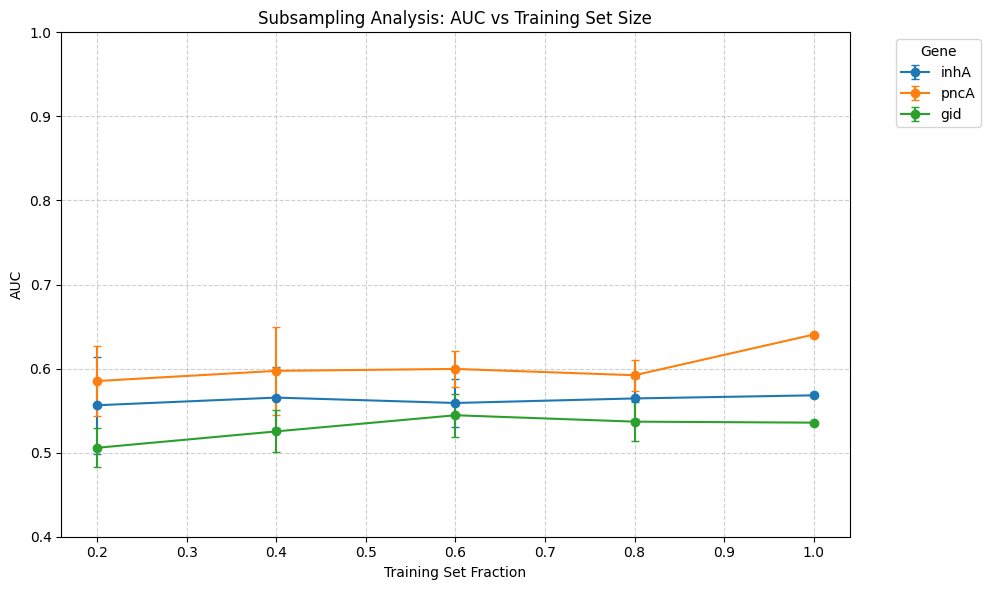

In [56]:
subsampling_results = pd.DataFrame(subsampling_rows)
# Plotting the data
plt.figure(figsize=(10, 6))

for _, row in subsampling_results.iterrows():
    train_fracs = row['train_fracs']
    mean_aucs = row['mean_aucs']
    std_aucs = row['std_aucs']

    plt.errorbar(
        train_fracs,
        mean_aucs,
        yerr=std_aucs,
        label=row['gene'],
        marker='o',
        capsize=3,
        linestyle='-'
    )

plt.title("Subsampling Analysis: AUC vs Training Set Size")
plt.xlabel("Training Set Fraction")
plt.ylabel("AUC")
plt.ylim(0.4, 1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Gene", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()
